In [3]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=9, micro=5, releaselevel='final', serial=0)

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [5]:
train = pd.read_csv('sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')

# Data Cleaning

## Sales Train Data

In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


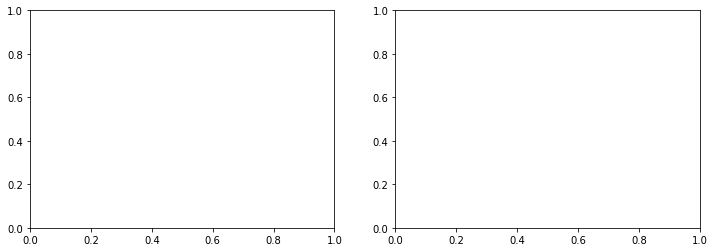

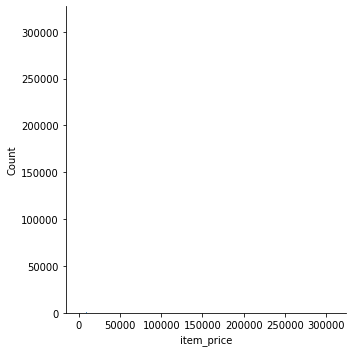

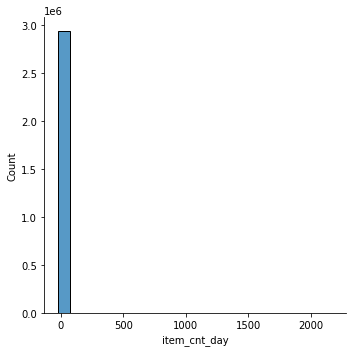

In [11]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (12,4))

sns.displot(train['item_price'], kde= False, ax= ax[0])
sns.displot(train['item_cnt_day'], kde= False, ax= ax[1])

<AxesSubplot:xlabel='item_cnt_day'>

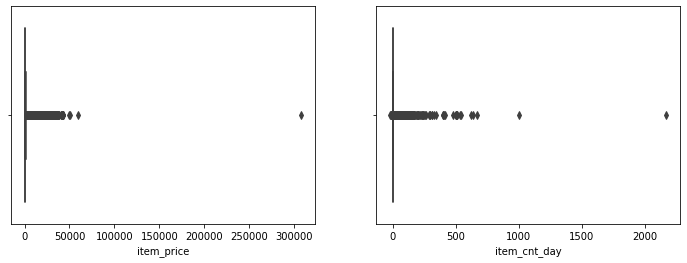

In [12]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (12,4))

sns.boxplot(x = train['item_price'],ax= ax[0])
sns.boxplot(x = train['item_cnt_day'],ax= ax[1])

In [13]:
train[['item_price', 'item_cnt_day']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [14]:
train['item_price'].nlargest(5)

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2885692     42990.0
Name: item_price, dtype: float64

In [15]:
train['item_cnt_day'].nlargest(5)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

We will drop the outlier values with Sales Price > 100,000 or Item_Count > 1000 

In [16]:
train = train[train['item_price'] < 100000]
train = train[train['item_cnt_day'] < 1001]

In [17]:
train['item_price'].nsmallest(5)

484683   -1.0000
579766    0.0700
608763    0.0700
611400    0.0875
673155    0.0900
Name: item_price, dtype: float64

In [18]:
train[train['item_price'] <0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [19]:
median_value = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & (train['item_price'] > 0)]['item_price'].median()

train.loc[train.item_price<0, 'item_price'] = median_value

## Shops Data

In [20]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [21]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [22]:
shop_names = list(shops['shop_name'])

In [23]:
print(f"Unique Number of Shop Names : {shops['shop_name'].nunique()}")
print(f"Unique Number of Shop IDs : {shops['shop_id'].nunique()}")

Unique Number of Shop Names : 60
Unique Number of Shop IDs : 60


Each Shop Name contains City name in the start. We will extract the city information from the shop name

In [24]:
shops['city_name'] = shops['shop_name'].apply(lambda x : x.split()[0])
shops.head()

,shop_name,shop_id,city_name
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [25]:
shops.drop('shop_name', axis= 1, inplace= True)
shops.head()

,shop_id,city_name
0,0,!Якутск
1,1,!Якутск
2,2,Адыгея
3,3,Балашиха
4,4,Волжский


In [26]:
label_encoder = LabelEncoder()
shops['city_code'] = label_encoder.fit_transform(shops['city_name'])

In [27]:
shops.drop('city_name', axis= 1, inplace= True)
shops.head()

,shop_id,city_code
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


## Item & Item Category Data

In [28]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [29]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [30]:
#Creating Item type & subtype features
cats['item_type'] = cats['item_category_name'].apply(lambda x : x.split('-')[0].strip())
cats['item_subtype'] = cats['item_category_name'].apply(lambda x : x.split('-')[1].strip() if len(x.split('-')) > 1 else x.split('-')[0].strip())

#Encoding them
cats['item_type_code'] = LabelEncoder().fit_transform(cats['item_type'])
cats['item_subtype_code'] = LabelEncoder().fit_transform(cats['item_subtype'])

In [31]:
cats.drop(['item_category_name', 'item_type', 'item_subtype'], axis= 1, inplace= True)
cats.head()

,item_category_id,item_type_code,item_subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [32]:
items = items.merge(cats, on= 'item_category_id', how= 'left')

In [33]:
items.drop('item_name', inplace= True, axis= 1)
items.head()

,item_id,item_category_id,item_type_code,item_subtype_code
0,0,40,11,4
1,1,76,15,31
2,2,40,11,4
3,3,40,11,4
4,4,40,11,4


## Monthly Sales

In [34]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [35]:
#Items which are present in Test but not in Train set
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))

363

In [36]:
print(f"Unique Items in Test Set: {test['item_id'].nunique()}")
print(f"Unique Shops in Test Set: {test['shop_id'].nunique()}")
print(f"Total Shop Item pairs : {len(test)}")

Unique Items in Test Set: 5100
Unique Shops in Test Set: 42
Total Shop Item pairs : 214200


In [37]:
train['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [38]:
matrix = []

cols = ['date_block_num', 'shop_id', 'item_id']

for i in range(34) :
    sales = train[train['date_block_num'] == i]
    matrix.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique() )), dtype='int16'))

In [39]:
matrix = pd.DataFrame(np.vstack(matrix), columns= cols)

In [40]:
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [41]:
matrix.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [42]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day' : 'sum'})
group.columns = ['item_cnt_month']
group.reset_index(inplace = True)

In [89]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [90]:
matrix = pd.merge(matrix, group, on= cols, how ='left')

In [92]:
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)

In [93]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [95]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [98]:
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [99]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) 

In [100]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


## Pulling Item & Shop features

In [101]:
#pulling shop features
matrix = pd.merge(matrix, shops, on= 'shop_id', how= 'left')
matrix = pd.merge(matrix, items, on= 'item_id', how= 'left')

In [102]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_type_code,item_subtype_code
0,0,0,19,0.0,0,40,11,4
1,0,0,27,0.0,0,19,5,10
2,0,0,28,0.0,0,30,8,55
3,0,0,29,0.0,0,23,5,16
4,0,0,32,6.0,0,40,11,4


In [103]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   date_block_num     int8   
 1   shop_id            int8   
 2   item_id            int16  
 3   item_cnt_month     float16
 4   city_code          int32  
 5   item_category_id   int64  
 6   item_type_code     int32  
 7   item_subtype_code  int32  
dtypes: float16(1), int16(1), int32(3), int64(1), int8(2)
memory usage: 360.8 MB


In [104]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['item_type_code'] = matrix['item_type_code'].astype(np.int8)
matrix['item_subtype_code'] = matrix['item_subtype_code'].astype(np.int8)

In [105]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_type_code,item_subtype_code
0,0,0,19,0.0,0,40,11,4
1,0,0,27,0.0,0,19,5,10
2,0,0,28,0.0,0,30,8,55
3,0,0,29,0.0,0,23,5,16
4,0,0,32,6.0,0,40,11,4


## Adding Target Lags

In [109]:
lags = [1,2,3,6,12]

for lag in lags :
    matrix[f'Previous_{lag}_month_sales'] = matrix.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)

In [111]:
matrix.fillna(0, inplace= True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_type_code,item_subtype_code,Previous_1_month_sales,Previous_2_month_sales,Previous_3_month_sales,Previous_6_month_sales,Previous_12_month_sales
0,0,0,19,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0
1,0,0,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,0.0
2,0,0,28,0.0,0,30,8,55,0.0,0.0,0.0,0.0,0.0
3,0,0,29,0.0,0,23,5,16,0.0,0.0,0.0,0.0,0.0
4,0,0,32,6.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0


## Mean Encoded Features

In [132]:
def mean_encoded_features(matrix, columns, lags) :
    
    group = matrix.groupby(columns).agg({'item_cnt_month' : 'mean'})
    new_column_name = '_'.join(columns) + '_item_cnt'
    group.columns = [new_column_name] 
    group.reset_index(inplace = True)
    
    matrix = pd.merge(matrix, group, on= columns, how= 'left')
    matrix[new_column_name] = matrix[new_column_name].astype(np.float16)
    
    for lag in lags :
        matrix[f'lag_{lag + 1}_{new_column_name}'] = matrix.groupby(['shop_id', 'item_id'])[new_column_name].shift(lag)
        
    matrix.drop(new_column_name, axis=1, inplace=True)
        
    return matrix
        

In [133]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'item_type_code', 'item_subtype_code',
       'Previous_1_month_sales', 'Previous_2_month_sales',
       'Previous_3_month_sales', 'Previous_6_month_sales',
       'Previous_12_month_sales'],
      dtype='object')

In [134]:
#Month Sales Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num'], lags= [1])

#Month Item Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'item_id'], lags= [1,2,3,6,12])

#Month Shop Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'shop_id'], lags= [1,2,3,6,12])

#Month Item Category Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'item_category_id'], lags= [1,2,3,6,12])

#Month Shop Category Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'shop_id', 'item_category_id'], lags= [1])

#Month Shop Type Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'shop_id', 'item_type_code'], lags= [1])

#Month Shop SubType Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'shop_id', 'item_subtype_code'], lags= [1])

#Month City Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'city_code'], lags= [1])

#Month Item City Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'item_id', 'city_code'], lags= [1])

#Month Type Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'item_type_code'], lags= [1])

#Month Sub-Type Level
matrix = mean_encoded_features(matrix, columns= ['date_block_num', 'item_subtype_code'], lags= [1])


In [136]:
matrix.fillna(0, inplace= True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_type_code,item_subtype_code,Previous_1_month_sales,Previous_2_month_sales,...,lag_4_date_block_num_item_category_id_item_cnt,lag_7_date_block_num_item_category_id_item_cnt,lag_13_date_block_num_item_category_id_item_cnt,lag_2_date_block_num_shop_id_item_category_id_item_cnt,lag_2_date_block_num_shop_id_item_type_code_item_cnt,lag_2_date_block_num_shop_id_item_subtype_code_item_cnt,lag_2_date_block_num_city_code_item_cnt,lag_2_date_block_num_item_id_city_code_item_cnt,lag_2_date_block_num_item_type_code_item_cnt,lag_2_date_block_num_item_subtype_code_item_cnt
0,0,0,19,0.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,27,0.0,0,19,5,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,28,0.0,0,30,8,55,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,29,0.0,0,23,5,16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,32,6.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Trend Features

In [138]:
#Adding avg price of each item
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_price'] = matrix['item_avg_price'].astype(np.float16)

In [140]:
#Adding Average Price every month of each item
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_price'] = matrix['date_item_avg_price'].astype(np.float16)

In [141]:
diff = [1,2,3,6,12]

for d in diff :
    matrix[f'Delta_{d}_price'] = matrix.groupby(['date_block_num', 'item_id'])['date_item_avg_price'].diff(d)
    
matrix.fillna(0, inplace = True)

In [142]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_type_code,item_subtype_code,Previous_1_month_sales,Previous_2_month_sales,...,lag_2_date_block_num_item_id_city_code_item_cnt,lag_2_date_block_num_item_type_code_item_cnt,lag_2_date_block_num_item_subtype_code_item_cnt,item_avg_price,date_item_avg_price,Delta_1_price,Delta_2_price,Delta_3_price,Delta_6_price,Delta_12_price
0,0,0,19,0.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,28.000,28.0,0.0,0.0,0.0,0.0,0.0
1,0,0,27,0.0,0,19,5,10,0.0,0.0,...,0.0,0.0,0.0,1461.000,2324.0,0.0,0.0,0.0,0.0,0.0
2,0,0,28,0.0,0,30,8,55,0.0,0.0,...,0.0,0.0,0.0,310.000,549.0,0.0,0.0,0.0,0.0,0.0
3,0,0,29,0.0,0,23,5,16,0.0,0.0,...,0.0,0.0,0.0,1759.000,2398.0,0.0,0.0,0.0,0.0,0.0
4,0,0,32,6.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,249.625,338.0,0.0,0.0,0.0,0.0,0.0


In [148]:
matrix.drop(['Delta_1_price','Delta_2_price','Delta_3_price','Delta_6_price','Delta_12_price', 'date_item_avg_price'], axis= 1, 
            inplace= True)

It can be observed no change in price is observed and this we will drop the Delta in price columns

## First Time Sale

In [153]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

## Revenue

In [150]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [151]:
#Month & Shop wise revenue
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

#Shop wise Revenue
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = mean_encoded_features(matrix, columns= ['delta_revenue'], lags= [1])

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

## Special Features

In [152]:
#month as per calender
matrix['month'] = matrix['date_block_num'] % 12

#number of days in the month 
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

## Final Preparations

Dropping records which are 12 months ago as their data will get already reflected in lag 12 terms

In [154]:
#dropping intial 12 months data
matrix = matrix[matrix.date_block_num > 11]

In [155]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'item_type_code', 'item_subtype_code',
       'Previous_1_month_sales', 'Previous_2_month_sales',
       'Previous_3_month_sales', 'Previous_6_month_sales',
       'Previous_12_month_sales', 'lag_2_date_block_num_item_cnt',
       'lag_2_date_block_num_item_id_item_cnt',
       'lag_3_date_block_num_item_id_item_cnt',
       'lag_4_date_block_num_item_id_item_cnt',
       'lag_7_date_block_num_item_id_item_cnt',
       'lag_13_date_block_num_item_id_item_cnt',
       'lag_2_date_block_num_shop_id_item_cnt',
       'lag_3_date_block_num_shop_id_item_cnt',
       'lag_4_date_block_num_shop_id_item_cnt',
       'lag_7_date_block_num_shop_id_item_cnt',
       'lag_13_date_block_num_shop_id_item_cnt',
       'lag_2_date_block_num_item_category_id_item_cnt',
       'lag_3_date_block_num_item_category_id_item_cnt',
       'lag_4_date_block_num_item_category_id_item_cnt',
       'lag_7_date

In [156]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 43 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   date_block_num                                           int8   
 1   shop_id                                                  int8   
 2   item_id                                                  int16  
 3   item_cnt_month                                           float16
 4   city_code                                                int8   
 5   item_category_id                                         int8   
 6   item_type_code                                           int8   
 7   item_subtype_code                                        int8   
 8   Previous_1_month_sales                                   float16
 9   Previous_2_month_sales                                   float16
 10  Previous_3_month_sales             

In [157]:
matrix.to_pickle('data.pkl')

In [158]:
del matrix
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Algorithm

## XGboost

In [159]:
data = pd.read_pickle('data.pkl')

In [160]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'item_type_code', 'item_subtype_code',
       'Previous_1_month_sales', 'Previous_2_month_sales',
       'Previous_3_month_sales', 'Previous_6_month_sales',
       'Previous_12_month_sales', 'lag_2_date_block_num_item_cnt',
       'lag_2_date_block_num_item_id_item_cnt',
       'lag_3_date_block_num_item_id_item_cnt',
       'lag_4_date_block_num_item_id_item_cnt',
       'lag_7_date_block_num_item_id_item_cnt',
       'lag_13_date_block_num_item_id_item_cnt',
       'lag_2_date_block_num_shop_id_item_cnt',
       'lag_3_date_block_num_shop_id_item_cnt',
       'lag_4_date_block_num_shop_id_item_cnt',
       'lag_7_date_block_num_shop_id_item_cnt',
       'lag_13_date_block_num_shop_id_item_cnt',
       'lag_2_date_block_num_item_category_id_item_cnt',
       'lag_3_date_block_num_item_category_id_item_cnt',
       'lag_4_date_block_num_item_category_id_item_cnt',
       'lag_7_date

### Creating Validation & Test datasets

In [161]:
X_train = data[data['date_block_num'] < 33].drop('item_cnt_month', axis = 1)
y_train = data[data['date_block_num'] < 33]['item_cnt_month']

X_val = data[data['date_block_num'] == 33].drop('item_cnt_month', axis = 1)
y_val = data[data['date_block_num'] == 33]['item_cnt_month']

X_test = data[data['date_block_num'] == 34].drop('item_cnt_month', axis = 1)
y_test = data[data['date_block_num'] == 34]['item_cnt_month']

In [162]:
del data
gc.collect()

10912

In [163]:
start_time = time.time()

model = XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300, colsample_bytree=0.8, subsample=0.8, eta=0.3,seed=42)

model.fit(X_train, y_train, eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True, early_stopping_rounds = 10)

time.time() - ts

MemoryError: Unable to allocate 991. MiB for an array with shape (259850724,) and data type float32

In [1]:
import pickle

In [2]:
model = pickle.load(open('xgboost.pkl', 'rb'))

[02:50:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [6]:
data = pd.read_pickle('data.pkl')

In [16]:
features = list(data.drop('item_cnt_month', axis=1).columns)

In [18]:
len(features)

42

In [35]:
feature_imp = pd.Series(data= model.feature_importances_, index= features)

In [41]:
feature_imp = feature_imp.sort_values(ascending = False)

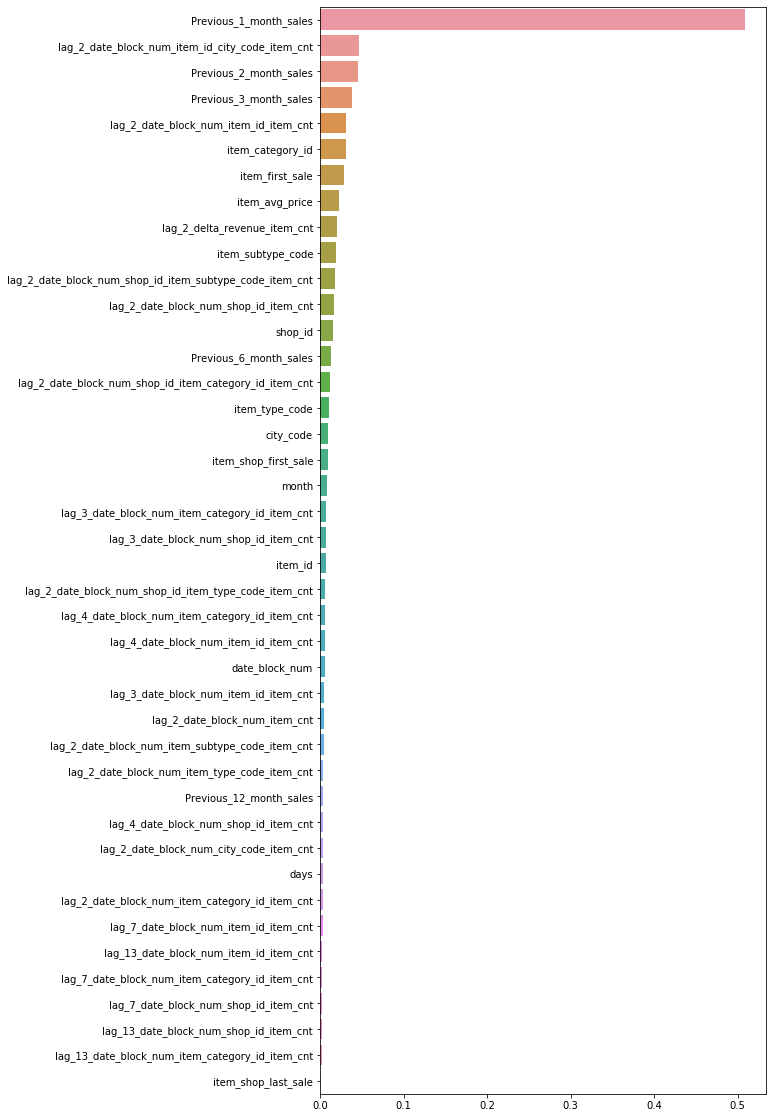

In [42]:
plt.figure(figsize = (8,20))
sns.barplot(y = feature_imp.index, x = feature_imp.values)